# Forecasting bus demand

In [2]:
import pandas as pd
from sklearn.metrics import mean_squared_error
from math import sqrt
from matplotlib import pyplot as plt
import numpy as np
import pmdarima as pm
from prophet import Prophet
import logging
logging.getLogger('fbprophet').setLevel(logging.WARNING)

In [3]:
pd.options.mode.chained_assignment = None  # default='warn'

In [4]:
df = pd.read_csv('municipality_bus_utilization.csv')

In [5]:
df.head(1)

,timestamp,municipality_id,usage,total_capacity
0,2017-06-04 07:59:42,9,454,1332


In [6]:
df.timestamp = pd.to_datetime(df.timestamp)

In [7]:
df.timestamp = df.timestamp.dt.tz_localize(None)

In [8]:
df.describe()

,municipality_id,usage,total_capacity
count,13070.000000,13070.000000,13070.000000
mean,4.500000,876.002984,1972.800000
std,2.872391,679.287109,1144.074782
min,0.000000,11.000000,397.000000
25%,2.000000,403.000000,697.000000
50%,4.500000,692.000000,1974.500000
75%,7.000000,1190.000000,2947.000000
max,9.000000,3508.000000,3893.000000


In [9]:
df['DATE'] = df.timestamp.apply(lambda x: str(x)[:10])
df['HOUR'] = df.timestamp.apply(lambda x: str(x)[11:13])

In [10]:
pd.isna(df).sum()

timestamp          0
municipality_id    0
usage              0
total_capacity     0
DATE               0
HOUR               0
dtype: int64

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13070 entries, 0 to 13069
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   timestamp        13070 non-null  datetime64[ns]
 1   municipality_id  13070 non-null  int64         
 2   usage            13070 non-null  int64         
 3   total_capacity   13070 non-null  int64         
 4   DATE             13070 non-null  object        
 5   HOUR             13070 non-null  object        
dtypes: datetime64[ns](1), int64(3), object(2)
memory usage: 612.8+ KB


In [12]:
df.groupby(['municipality_id']).count()

,timestamp,usage,total_capacity,DATE,HOUR
municipality_id,,,,,
0,1307,1307,1307,1307,1307
1,1307,1307,1307,1307,1307
2,1307,1307,1307,1307,1307
3,1307,1307,1307,1307,1307
4,1307,1307,1307,1307,1307
5,1307,1307,1307,1307,1307
6,1307,1307,1307,1307,1307
7,1307,1307,1307,1307,1307
8,1307,1307,1307,1307,1307


In [13]:
df.head(1)

,timestamp,municipality_id,usage,total_capacity,DATE,HOUR
0,2017-06-04 07:59:42,9,454,1332,2017-06-04,07


In [14]:
df['timestamp'] = df['timestamp'].apply(lambda x: pd.to_datetime(str(x)[:-5]+'00-00'))

In [15]:
df = df.groupby(['municipality_id', 'timestamp']).max().reset_index()

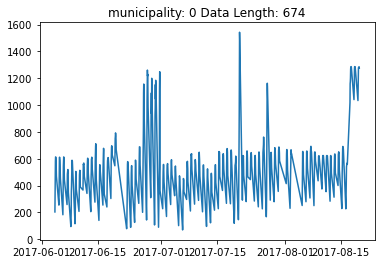

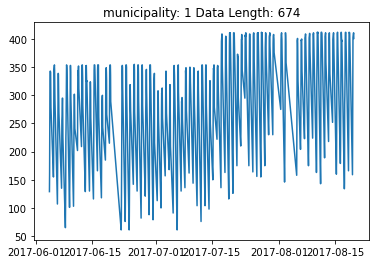

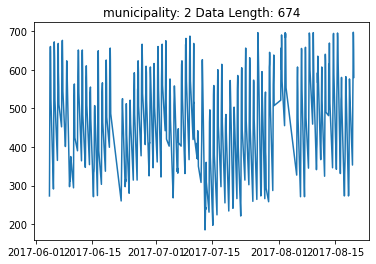

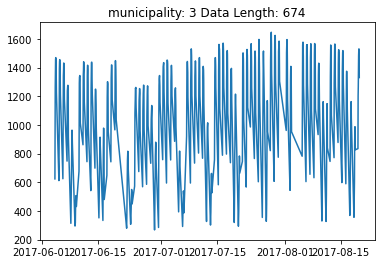

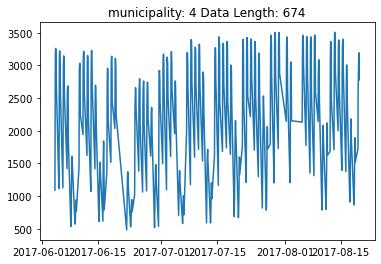

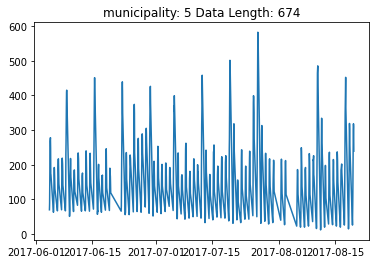

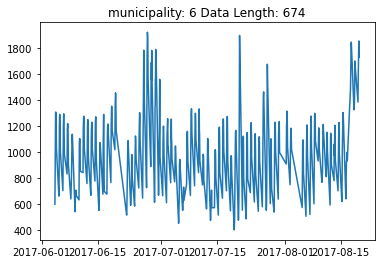

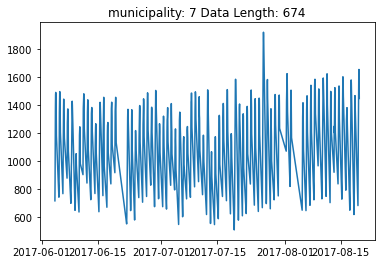

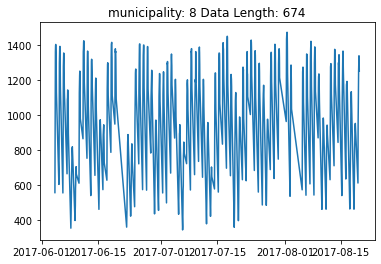

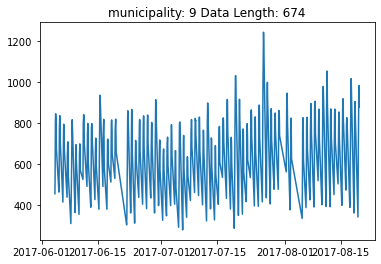

In [16]:
for municipality in df.municipality_id.unique():
    df_t = df.loc[df.municipality_id==municipality]
    plt.title(f"municipality: {municipality} Data Length: {len(df_t)}")
    plt.plot(df_t.timestamp, df_t.usage, label='Actual')
    plt.show()

In [17]:
# Missing Data points

In [18]:
df_copy = df.copy() # get copy of the data

In [19]:
dates_for_missings = pd.date_range(start=min(df.timestamp), end=max(df.timestamp), freq='H')

In [20]:
min(df.HOUR),max(df.HOUR) # we have 7 to 16 everyday

('07', '16')

In [21]:
dates_for_missings = pd.DataFrame(dates_for_missings, columns={'timestamp'})

In [22]:
dates_for_missings['HOUR'] = dates_for_missings.timestamp.apply(lambda x: str(x)[11:13])
dates_for_missings['DATE'] = dates_for_missings.timestamp.apply(lambda x: str(x)[:10])

In [23]:
dates_for_missings = dates_for_missings.loc[(dates_for_missings.HOUR>=min(df.HOUR)) & (dates_for_missings.HOUR<=max(df.HOUR))]

In [24]:
dates_for_missings.head(1)

,timestamp,HOUR,DATE
0,2017-06-04 07:00:00+00:00,07,2017-06-04


In [25]:
# fill data
temp_list = []
for municipality in df.municipality_id.unique():
    df_t = df.loc[df.municipality_id==municipality][['municipality_id','timestamp','usage','DATE', 'HOUR']]
    
    # concat
    dates_for_concat = dates_for_missings.loc[~dates_for_missings.timestamp.isin(df_t.timestamp)].copy()
    
    dates_for_concat['municipality_id'] = [municipality] * len(dates_for_concat)
    dates_for_concat['usage'] = [np.nan] * len(dates_for_concat)
    
    df_merged = pd.concat([df_t, dates_for_concat])
    temp_list.append(df_merged)

In [26]:
df = pd.concat(temp_list)

In [27]:
pd.isna(df).sum()

municipality_id      0
timestamp            0
usage              960
DATE                 0
HOUR                 0
dtype: int64

In [28]:
df.head()

,municipality_id,timestamp,usage,DATE,HOUR
0,0,2017-06-04 07:00:00+00:00,204.0,2017-06-04,07
1,0,2017-06-04 08:00:00+00:00,332.0,2017-06-04,08
2,0,2017-06-04 09:00:00+00:00,485.0,2017-06-04,09
3,0,2017-06-04 10:00:00+00:00,583.0,2017-06-04,10
4,0,2017-06-04 11:00:00+00:00,614.0,2017-06-04,11


In [29]:
hourly_mean = df.groupby(['HOUR', 'municipality_id']).median().reset_index()

In [30]:
hourly_mean.head()

,HOUR,municipality_id,usage
0,07,0,208.5
1,07,1,132.0
2,07,2,318.0
3,07,3,577.0
4,07,4,1091.5


In [31]:
for municipality in df.municipality_id.unique():
    for hour in df.HOUR.unique():
        length = len(df.loc[(df.municipality_id==municipality) & (df.HOUR==hour) & pd.isna(df.usage)])
        
        df.loc[(df.municipality_id==municipality) & (df.HOUR==hour) & pd.isna(df.usage), 'usage'] =\
        float(hourly_mean.loc[(hourly_mean.municipality_id==municipality) & (hourly_mean.HOUR==hour)].usage.values)

In [32]:
df = df.sort_values('timestamp')
df.index = df.timestamp

In [33]:
pd.isna(df).sum()

municipality_id    0
timestamp          0
usage              0
DATE               0
HOUR               0
dtype: int64

In [34]:
df_test = df.loc['2017-08-05':'2017-08-19']
df_train = df.loc[:'2017-08-04']

In [35]:
df_test.head(2)

,municipality_id,timestamp,usage,DATE,HOUR
timestamp,,,,,
2017-08-05 07:00:00+00:00,9,2017-08-05 07:00:00+00:00,392.5,2017-08-05,07
2017-08-05 07:00:00+00:00,2,2017-08-05 07:00:00+00:00,318.0,2017-08-05,07


In [36]:
df_test.DATE.unique()

array(['2017-08-05', '2017-08-06', '2017-08-07', '2017-08-08',
       '2017-08-09', '2017-08-10', '2017-08-11', '2017-08-12',
       '2017-08-13', '2017-08-14', '2017-08-15', '2017-08-16',
       '2017-08-17', '2017-08-18', '2017-08-19'], dtype=object)

In [37]:
df_train.head(2)

,municipality_id,timestamp,usage,DATE,HOUR
timestamp,,,,,
2017-06-04 07:00:00+00:00,0,2017-06-04 07:00:00+00:00,204.0,2017-06-04,07
2017-06-04 07:00:00+00:00,6,2017-06-04 07:00:00+00:00,597.0,2017-06-04,07


In [38]:
df_train.DATE.unique()

array(['2017-06-04', '2017-06-05', '2017-06-06', '2017-06-07',
       '2017-06-08', '2017-06-09', '2017-06-10', '2017-06-11',
       '2017-06-12', '2017-06-13', '2017-06-14', '2017-06-15',
       '2017-06-16', '2017-06-17', '2017-06-18', '2017-06-19',
       '2017-06-20', '2017-06-21', '2017-06-22', '2017-06-23',
       '2017-06-24', '2017-06-25', '2017-06-26', '2017-06-27',
       '2017-06-28', '2017-06-29', '2017-06-30', '2017-07-01',
       '2017-07-02', '2017-07-03', '2017-07-04', '2017-07-05',
       '2017-07-06', '2017-07-07', '2017-07-08', '2017-07-09',
       '2017-07-10', '2017-07-11', '2017-07-12', '2017-07-13',
       '2017-07-14', '2017-07-15', '2017-07-16', '2017-07-17',
       '2017-07-18', '2017-07-19', '2017-07-20', '2017-07-21',
       '2017-07-22', '2017-07-23', '2017-07-24', '2017-07-25',
       '2017-07-26', '2017-07-27', '2017-07-28', '2017-07-29',
       '2017-07-30', '2017-07-31', '2017-08-01', '2017-08-02',
       '2017-08-03', '2017-08-04'], dtype=object)

In [39]:
future = pd.DataFrame(df_test.timestamp.unique(), columns={'ds'})
future['ds'] = future.ds.dt.tz_localize(None)

# MODEL 1

In [40]:
sarima_result = []
for municipality in df.municipality_id.unique():
    df_temp = df_train.loc[df_train.municipality_id == municipality]
    df_train_model_1 = df_temp[['usage']]
    df_temp['timestamp'] = df_temp['timestamp'].dt.tz_localize(None)
    df_train_model_1.index = df_temp['timestamp']

    model = pm.auto_arima(df_train_model_1, seasonal=True, m = 10, suppress_warnings=True, 
                          initialization='approximate_diffuse', error_action='ignore')
    
    temp_resuls = pd.DataFrame(model.predict(len(future)), columns={'yhat'})
    temp_resuls['timestamp'] = future.values
    temp_resuls['municipality_id'] = [municipality] * len(future)
    sarima_result.append(temp_resuls)

In [41]:
df_sarima_result = pd.concat(sarima_result)

In [42]:
df_test_sarima = df_test.copy()

In [43]:
del df_test_sarima['timestamp']
df_test_sarima = df_test_sarima.reset_index()
df_test_sarima['timestamp'] = df_test_sarima.timestamp.dt.tz_localize(None)
df_test_sarima = df_sarima_result.merge(df_test_sarima, on = ['timestamp', 'municipality_id'], how='inner')

In [44]:
df_test_sarima.head(1)

,yhat,timestamp,municipality_id,usage,DATE,HOUR
0,240.147571,2017-08-05 07:00:00,0,208.5,2017-08-05,07


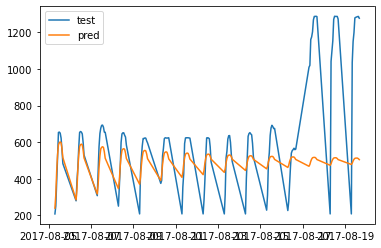

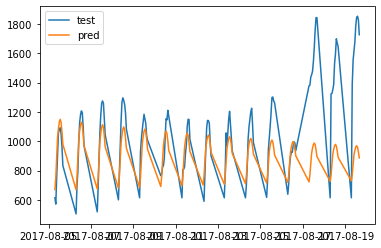

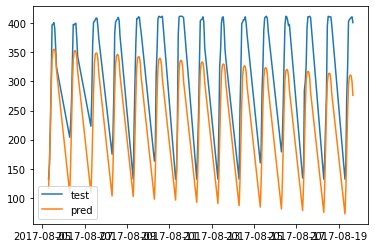

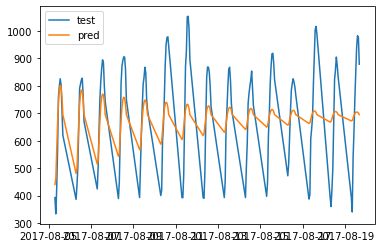

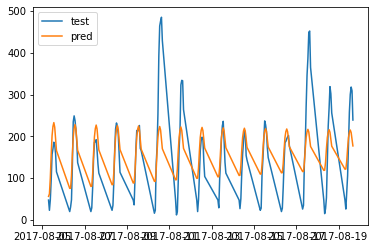

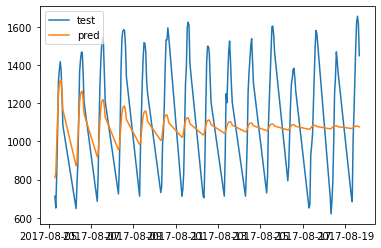

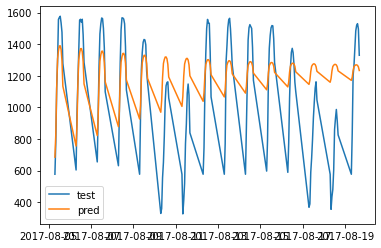

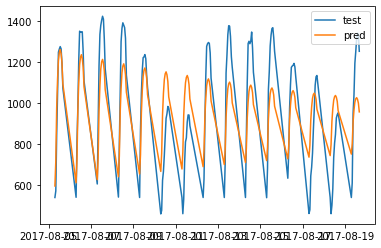

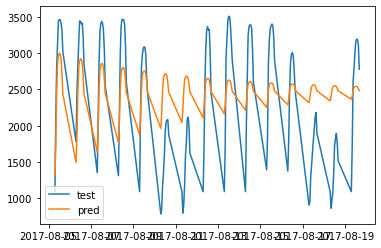

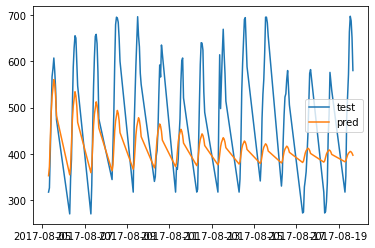

In [45]:
for municipality in df_test_sarima.municipality_id.unique():
    test = df_test_sarima.loc[df_test_sarima.municipality_id == municipality]
    plt.plot(test.timestamp, test.usage, label='test')
    plt.plot(test.timestamp, test.yhat, label='pred')
    plt.legend()
    plt.show()

In [46]:
df_test_sarima_first_week = df_test_sarima.loc[df_test_sarima.DATE<='2017-08-11']
df_test_sarima_second_week = df_test_sarima.loc[df_test_sarima.DATE>'2017-08-11']

In [47]:
rmse_firts_week = sqrt(mean_squared_error(df_test_sarima_first_week.usage, df_test_sarima_first_week.yhat))
rmse_second_week = sqrt(mean_squared_error(df_test_sarima_second_week.usage, df_test_sarima_second_week.yhat))

In [48]:
rmse_firts_week, rmse_second_week

(262.2473220716845, 356.6933146703827)

# MODEL 2

In [49]:
prophet_result = []

for municipality in df.municipality_id.unique():
    df_temp = df_train.loc[df_train.municipality_id == municipality]
    df_train_prophet = df_temp[['usage']]    
    df_train_prophet['ds'] = df_temp['timestamp']
    df_train_prophet = df_train_prophet.rename(columns={'usage':'y'})
    df_train_prophet = df_train_prophet.reset_index()
    del df_train_prophet['timestamp']
    df_train_prophet['ds'] = df_train_prophet.ds.dt.tz_localize(None)
    
    m = Prophet(changepoint_prior_scale=0.01)
    m.fit(df_train_prophet)
    forecast = m.predict(future)
    
    forecast['municipality_id'] = [municipality] * len(forecast)
    prophet_result.append(forecast)

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=Tru

In [50]:
df_prophet_result = pd.concat(prophet_result)

In [51]:
prophet_result[0]

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,daily_lower,daily_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat,municipality_id
0,2017-08-05 07:00:00,429.885260,-17.248702,381.289516,429.885208,429.886554,-241.603414,-241.603414,-241.603414,-204.258611,-204.258611,-204.258611,-37.344803,-37.344803,-37.344803,0.0,0.0,0.0,188.281846,0
1,2017-08-05 08:00:00,429.923570,98.253839,460.664707,429.923218,429.925224,-162.313445,-162.313445,-162.313445,-126.955631,-126.955631,-126.955631,-35.357814,-35.357814,-35.357814,0.0,0.0,0.0,267.610125,0
2,2017-08-05 09:00:00,429.961880,197.233511,570.479228,429.961218,429.963961,-36.586589,-36.586589,-36.586589,-3.364971,-3.364971,-3.364971,-33.221618,-33.221618,-33.221618,0.0,0.0,0.0,393.375291,0
3,2017-08-05 10:00:00,430.000190,320.035582,687.994240,429.999300,430.002975,82.283094,82.283094,82.283094,113.240090,113.240090,113.240090,-30.956996,-30.956996,-30.956996,0.0,0.0,0.0,512.283284,0
4,2017-08-05 11:00:00,430.038500,400.235271,792.275480,430.037392,430.041841,162.274315,162.274315,162.274315,190.859852,190.859852,190.859852,-28.585537,-28.585537,-28.585537,0.0,0.0,0.0,592.312815,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145,2017-08-19 12:00:00,442.948957,470.009567,839.084322,442.327487,443.638919,206.483732,206.483732,206.483732,232.613094,232.613094,232.613094,-26.129362,-26.129362,-26.129362,0.0,0.0,0.0,649.432690,0
146,2017-08-19 13:00:00,442.987267,476.809697,871.126246,442.362263,443.681884,231.858549,231.858549,231.858549,255.469391,255.469391,255.469391,-23.610842,-23.610842,-23.610842,0.0,0.0,0.0,674.845817,0
147,2017-08-19 14:00:00,443.025577,506.731347,885.721865,442.396502,443.724849,239.988453,239.988453,239.988453,261.040780,261.040780,261.040780,-21.052327,-21.052327,-21.052327,0.0,0.0,0.0,683.014030,0
148,2017-08-19 15:00:00,443.063887,466.294427,846.531590,442.430741,443.767814,212.699618,212.699618,212.699618,231.175486,231.175486,231.175486,-18.475869,-18.475869,-18.475869,0.0,0.0,0.0,655.763505,0


In [52]:
df_prophet_result.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,daily_lower,daily_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat,municipality_id
0,2017-08-05 07:00:00,429.88526,-17.248702,381.289516,429.885208,429.886554,-241.603414,-241.603414,-241.603414,-204.258611,-204.258611,-204.258611,-37.344803,-37.344803,-37.344803,0.0,0.0,0.0,188.281846,0
1,2017-08-05 08:00:00,429.92357,98.253839,460.664707,429.923218,429.925224,-162.313445,-162.313445,-162.313445,-126.955631,-126.955631,-126.955631,-35.357814,-35.357814,-35.357814,0.0,0.0,0.0,267.610125,0
2,2017-08-05 09:00:00,429.96188,197.233511,570.479228,429.961218,429.963961,-36.586589,-36.586589,-36.586589,-3.364971,-3.364971,-3.364971,-33.221618,-33.221618,-33.221618,0.0,0.0,0.0,393.375291,0
3,2017-08-05 10:00:00,430.00019,320.035582,687.994240,429.999300,430.002975,82.283094,82.283094,82.283094,113.240090,113.240090,113.240090,-30.956996,-30.956996,-30.956996,0.0,0.0,0.0,512.283284,0
4,2017-08-05 11:00:00,430.03850,400.235271,792.275480,430.037392,430.041841,162.274315,162.274315,162.274315,190.859852,190.859852,190.859852,-28.585537,-28.585537,-28.585537,0.0,0.0,0.0,592.312815,0


In [53]:
df_test_prophet = df_test.copy()

In [54]:
del df_test_prophet['timestamp']

In [55]:
df_test_prophet = df_test_prophet.reset_index()

In [56]:
df_test_prophet.timestamp = df_test_prophet.timestamp.dt.tz_localize(None)

In [57]:
df_test_prophet = df_test_prophet.rename(columns={'timestamp' : 'ds'})

In [58]:
df_test_prophet.head()

,ds,municipality_id,usage,DATE,HOUR
0,2017-08-05 07:00:00,9,392.5,2017-08-05,07
1,2017-08-05 07:00:00,2,318.0,2017-08-05,07
2,2017-08-05 07:00:00,8,540.0,2017-08-05,07
3,2017-08-05 07:00:00,4,1091.5,2017-08-05,07
4,2017-08-05 07:00:00,6,614.0,2017-08-05,07


In [59]:
df_test_prophet = df_test_prophet.merge(df_prophet_result, on=['ds', 'municipality_id'], how='inner')

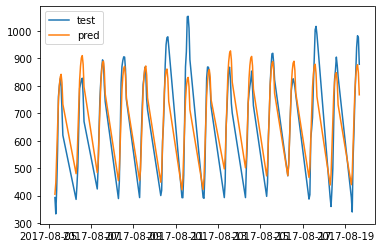

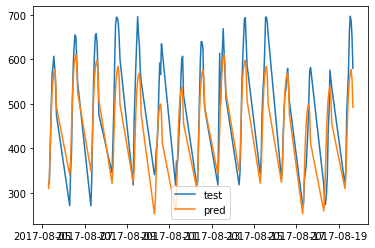

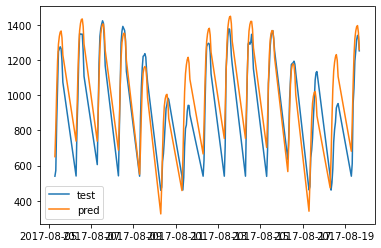

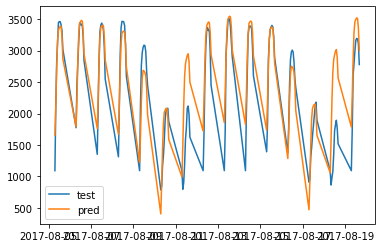

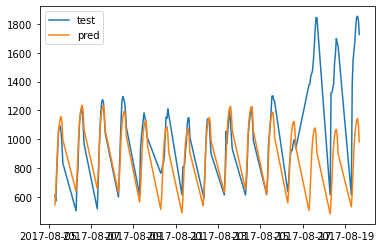

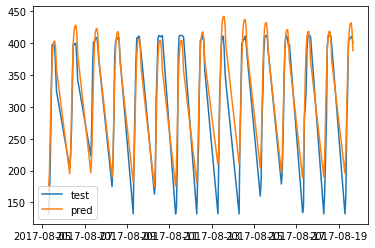

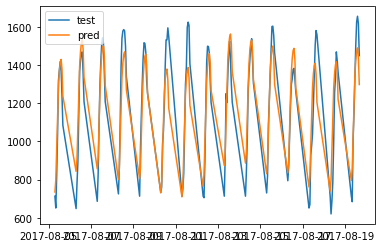

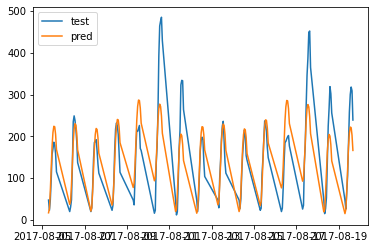

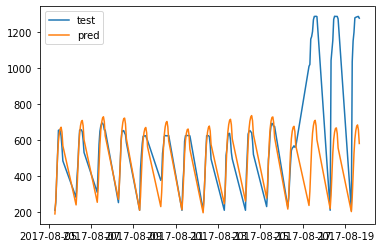

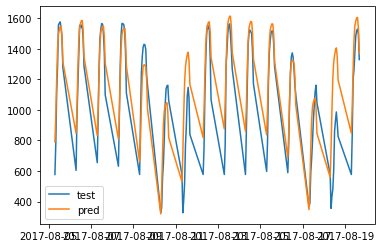

In [60]:
for municipality in df_test_prophet.municipality_id.unique():
    test = df_test_prophet.loc[df_test_prophet.municipality_id == municipality]
    plt.plot(test.ds, test.usage, label='test')
    plt.plot(test.ds, test.yhat, label='pred')
    plt.legend()
    plt.show()

In [61]:
df_test_prophet_first_week = df_test_prophet.loc[df_test_prophet.DATE<='2017-08-11']
df_test_prophet_second_week = df_test_prophet.loc[df_test_prophet.DATE>'2017-08-11']

In [62]:
rmse_firt_week_pr = sqrt(mean_squared_error(df_test_prophet_first_week.usage, df_test_prophet_first_week.yhat))
rmse_second_week_pr = sqrt(mean_squared_error(df_test_prophet_second_week.usage, df_test_prophet_second_week.yhat))

In [63]:
rmse_firt_week_pr, rmse_second_week_pr

(170.21066948797719, 258.1520086319637)